In [ ]:
# Picture of setup

![](drum.jpg)
![](drum_xray.jpg)

# References

- @inproceedings{aimi2007percussion,
  title={Percussion instruments using realtime convolution: Physical controllers},
  author={Aimi, Roberto},
  booktitle={Proceedings of the 7th international conference on New interfaces for musical expression},
  pages={154--159},
  year={2007},
  organization={ACM}
}


In [1]:
diam_drum = .19685 # meters +/- .005

# Two datasets

1. TDOA (and speed of sound, $c$) (scratch_data.tar.gz)

2. $\gamma$, $\lambda_{mn}$, $a_{mn}$, $b_{mn}$ (tap_data_no_gain.tar.gz)

In [33]:
%matplotlib inline

from __future__ import division

import matplotlib.pyplot as plt
from numpy import (argmax, abs, correlate, floor, arange, real,
                   conjugate, concatenate, cos, exp)
from numpy.fft import fft, ifft, fftfreq
from scipy.signal import correlate, argrelmax, argrelmin, welch
from scipy.special import j0, jn_zeros
from scipy import stats
from jacked import easy_client
from glob import glob
from numpy import savetxt, loadtxt
from os.path import splitext
from os import rename
import time
import numpy as np

# Capture data

- Data now stored at: https://archive.org/edit/tap_data.tar.gz

In [3]:
with easy_client(name="captest", channels_in=2, channels_out=2) as client:
    captured = client.capture(sec=2)

NotConnectedError: Failed to connect to Jack audio server.

In [4]:
SAMPLE_RATE = 96000

In [5]:
WINDOW_SIZE = 2**12
WINDOW_SIZE

4096

In [6]:
plt.plot(captured[0])
plt.xlim(25000, 50000)
plt.show()

plt.magnitude_spectrum(captured[0], Fs=SAMPLE_RATE)
plt.xlim(0, 1000)
plt.show()

plt.plot(captured[1])
plt.xlim(25000, 50000)
plt.show()

plt.magnitude_spectrum(captured[1], Fs=SAMPLE_RATE)
plt.xlim(0, 500)
plt.show()

tdoa_1 = tdoa(captured, start=25000, n=25000, debug=True)

.1016/0.00885

NameError: name 'captured' is not defined

In [7]:
plt.plot(captured_1[0])
plt.plot(captured_1[1])
plt.plot(captured_1[2])
plt.xlim(157000, 165000)

plt.show()
tdoa_1 = tdoa(captured_1, start=157000, n=165000-157000, debug=True)

NameError: name 'captured_1' is not defined

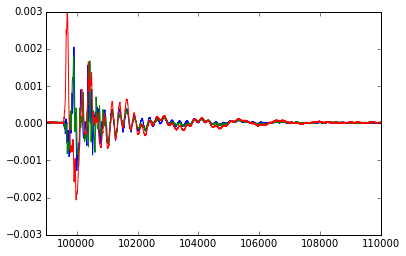

center: 5499.5
sample offset 0.5
tdoa: 5.20833333333e-06 sec
center: 5499.5
sample offset 225.5
tdoa: 0.00234895833333 sec
center: 5499.5
sample offset 209.5
tdoa: 0.00218229166667 sec


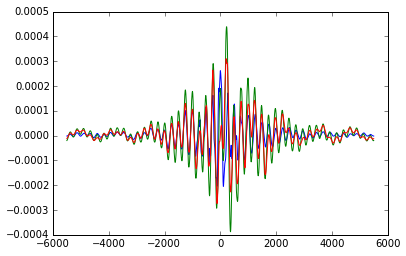

In [324]:
plt.plot(captured_2[0])
plt.plot(captured_2[1])
plt.plot(captured_2[2])
plt.xlim(99000, 110000)

plt.show()
tdoa_2 = tdoa(captured_2, start=99000, n=110000-99000, debug=True)

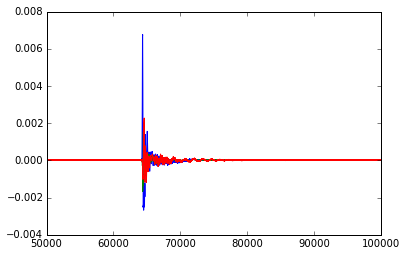

center: 24999.5
sample offset -205.5
tdoa: -0.002140625 sec
center: 24999.5
sample offset -217.5
tdoa: -0.002265625 sec
center: 24999.5
sample offset -1.5
tdoa: -1.5625e-05 sec


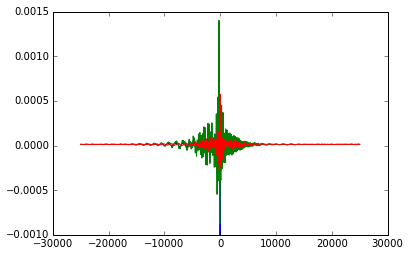

In [336]:
plt.plot(captured_3[0])
plt.plot(captured_3[1])
plt.plot(captured_3[2])
plt.xlim(50000, 100000)

plt.show()
tdoa_3 = tdoa(captured_3, start=50000, n=50000, debug=True)

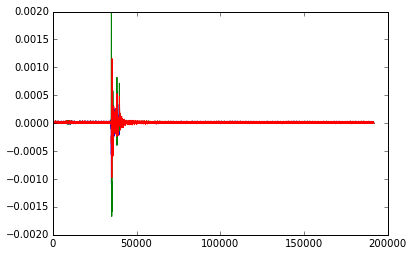

center: 24999.5
sample offset -249.5
tdoa: -0.00259895833333 sec
center: 24999.5
sample offset -1.5
tdoa: -1.5625e-05 sec
center: 24999.5
sample offset 243.5
tdoa: 0.00253645833333 sec


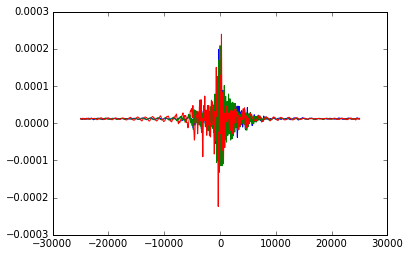

In [337]:
plt.plot(captured_4[0])
plt.plot(captured_4[1])
plt.plot(captured_4[2])

plt.show()
tdoa_4 = tdoa(captured_4, start=10000, n=50000, debug=True)

In [339]:
tdoa_1, tdoa_4, tdoa_2, tdoa_3

([-252.5, -1.5, 247.5],
 [-249.5, -1.5, 243.5],
 [0.5, 225.5, 209.5],
 [-205.5, -217.5, -1.5])

In [344]:
t_01 = 252.5/SAMPLE_RATE # sec
x_01 = .11938 # meters
v_01 = x_01/t_01

t_02 = 220.5/SAMPLE_RATE # sec
x_02 = 0.1016 # meters
v_02 = x_02/t_02

t_03 = 209.5/SAMPLE_RATE # sec
x_03 = 0.09398 # meters
v_03 = x_03/t_03

In [348]:
print(v_01, v_02, v_03)
c = np.mean([v_01, v_02, v_03])
print(c)

(45.388039603960394, 44.23401360544218, 43.06482100238664)
44.2289580706


# Attempt at TDOA
## Steps

1. cross correlate
2. find midpoint
3. compute argmax
4. argmax - midpoint is the time delay

In [13]:
from numpy import concatenate
from itertools import combinations

def tdoa(data, start, n=WINDOW_SIZE, debug=False):
    tdoa_list = []
    for i, j in combinations(range(data.shape[0]), 2):
        x0 = data[i, start:start+n]
        x1 = data[j, start:start+n]
        y = real(ifft(fft(x0)*conjugate(fft(x1))))
        right = y[0:len(y)/2]
        left = y[len(y)/2:-1]
        correlated = concatenate([left, right])
    
        center = len(correlated)/2
        max_index = argmax(correlated)
        offset = max_index - center
        tdoa_list.append(offset)
   
        if debug:
            plt.plot(arange(-center, center), correlated)
            print("center: {}".format(center))
            print("sample offset {}".format(offset))
            print("tdoa: {} sec".format(offset/SAMPLE_RATE))
    
    return tdoa_list

def tdoas(data, n=WINDOW_SIZE):
    tdoa_vecs = []
    for start in range(0, data.shape[1], n//2):
        tdoa_vecs.append(tdoa(data, start, n=n))
    return np.vstack(tdoa_vecs)

In [137]:
data = loadtxt("scratch_data/data1.txt")

[-18.5, -9.5, -47.5]

In [279]:
median_tdoas = []
for i, data in enumerate([loadtxt(path) for path in glob("scratch_data/*")]):
    x = tdoas(data)
    median_tdoas.append([np.median(x.T[i]) for i in range(3)])
Y = np.vstack(median_tdoas)

In [280]:
for i, row in enumerate(Y):
    print(i+1, row)

(1, array([-18.5, -17.5, -41.5]))
(2, array([ 70.5,  28.5,  38.5]))
(3, array([ 75.5,  30.5,   0.5]))
(4, array([ 72.5,  23.5,  -0.5]))
(5, array([ 71.5,  25.5,   3.5]))
(6, array([ -1.5,   4.5, -17.5]))
(7, array([ 64.5,   8.5, -20.5]))
(8, array([-61.5, -13.5,  71.5]))
(9, array([-71.5, -18.5,   3.5]))
(10, array([ 68.5,  25.5,   2.5]))
(11, array([  69.5,  204.5,    8.5]))
(12, array([ 68.5,  76.5,  14.5]))
(13, array([-66.5, -23.5,  46.5]))
(14, array([-73.5, -14.5,  49.5]))
(15, array([-18.5,  22.5,   6.5]))
(16, array([-58.5,  34.5,   1.5]))
(17, array([-58.5, -21.5,  -1.5]))
(18, array([  68.5,  -26.5,  122.5]))
(19, array([  71.5,  266.5,  193.5]))
(20, array([ 85.5, -29.5,  46.5]))
(21, array([ 19.5,  23.5,  -5.5]))
(22, array([ 19.5, -18.5,   1.5]))
(23, array([-17.5,  23.5,   4.5]))
(24, array([  9.5, -16.5,  18.5]))
(25, array([  9.5, -24.5,  20.5]))
(26, array([  -2.5,  206.5,   56.5]))
(27, array([ 85.5,  37.5,  53.5]))
(28, array([ 78.5, -22.5,  -9.5]))
(29, array([ 23.5

In [244]:
1/SAMPLE_RATE*70

0.0007291666666666666

# Comparison with expected solution

> $(\delta_r^2 + \frac{1}{r}\delta_r + \frac{1}{r^2}\delta_{\theta}^2) u = \frac{1}{c^2}\left(
\delta_t^2 + 2 \gamma \delta_t \right)u$

Where $r, \theta$ are cylindrical coordinates, $a$ is the damping coeff, and $c$ is the speed of sound for the material.

> $u_{mn}(r, \theta, t) = J_m(\lambda_{mn}r)[a_{mn}\cos(m \theta) + b_{mn}\sin(m\theta)] \cos{(t\sqrt{c^2 \lambda_{mn}^2 - \gamma^2})}\exp(-\gamma t)$

> $u(r, \theta, t) = \sum_{m=0} \sum_{n=1} u_{nm}$

- $\lambda_{mn} = \alpha_{mn}/R$
  - $\alpha_{mn}$ is the $n$th root of $J_m$

> $c = \sqrt{\frac{N^{*}_{rr}}{\rho h}}$
 
 - $c$ is the speed of sound in the medium
 - $h\equiv$ thickness
 - $N^{*}_{rr} \equiv$ is the radial membrane resultant on $\delta \Omega$
 - $\gamma$ is the attenuation factor
 
 For uniform tension:
 
> $c = \sqrt{\frac{T}{\rho h}}$
 
 - $T =$ Tension

- Fixing $\theta$ and $r$, modes are sinusoids decaying as $\exp(-\gamma t)$
- Varying $r$ and fixing $\theta$ and $t$ should result in Bessel functions
- Varying $\theta$ and fixing $t$ and $r$ should give sinusoids 

## Analysis with fixed $\theta$ and $r$

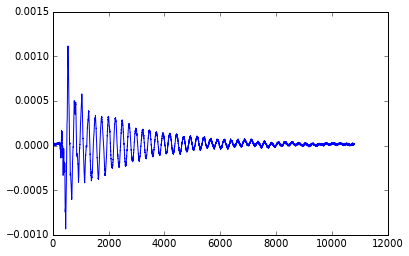

In [8]:
data = loadtxt("tap_no_gain.txt")
plt.plot(data)
plt.show()

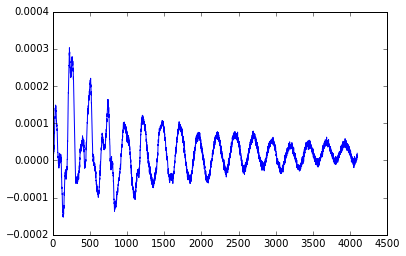

In [352]:
data = loadtxt("tap_data/data15.txt")[0][8000:8000+WINDOW_SIZE]
plt.plot(data)
plt.show()

In [40]:
import statsmodels.api as sm
import statsmodels.graphics as smgraphics
from statsmodels.formula.api import ols

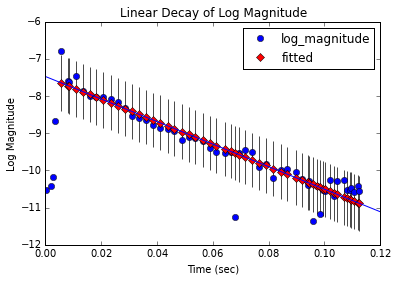

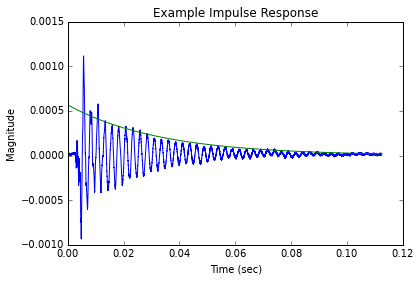

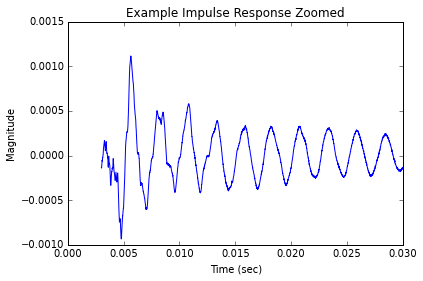

[   407.56464685   1333.84793516   2297.182555     3297.56850637
   4223.85179467   5113.08375145   5817.05905056   7039.75299112
   7595.52296411   8114.24160556   8818.21690467   9225.78155152
   9633.34619838  10115.0135083   10893.09147047  11522.96410652
  12375.14473176  12967.96603628  13523.73600926  14005.40331918
  15116.94326515  15932.07255886  16524.89386337  16969.50984176
  18340.40910845  19489.00038595  19970.66769587  20378.23234272
  21749.13160942  22712.46622926  23157.08220764  23786.95484369
  24824.39212659  25417.21343111  25898.88074103  26528.75337707
  27158.62601312  27714.39598611  28603.62794288  29122.34658433
  30270.93786183  30937.86182941  31345.42647626  31901.19644925
  33086.83905828  33531.45503667  34087.22500965  34494.7896565
  35235.81628715  36125.04824392  36754.92087997  38051.7174836
  38829.79544577  40423.00270166  41164.0293323   41571.59397916
  42571.97993053  43424.16055577  44165.18718641  44832.11115399
  45424.93245851  46610.575

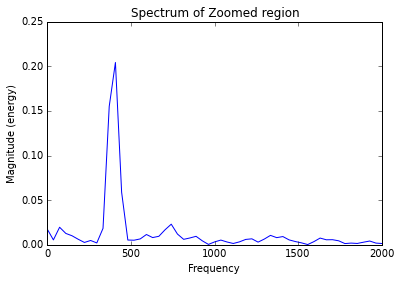

(30.293621171072054, 407.5646468544964, 407.53612804858318)
189.0
0.0330102497273


In [85]:
dt = 1/SAMPLE_RATE
peaks = argrelmax(data, order=40)[0]

x = dt*peaks[4:]
y = np.log(data[peaks][4:])
res = ols("log_magnitude ~ time", data={"log_magnitude": y, "time": x}).fit()
figure = smgraphics.regressionplots.plot_fit(res, 1)
smgraphics.regressionplots.abline_plot(model_results=res, ax=figure.axes[0])
plt.xlabel("Time (sec)")
plt.ylabel("Log Magnitude")
plt.title("Linear Decay of Log Magnitude")
plt.plot(dt*peaks[:4], np.log(data[peaks[:4]]), 'bo')
plt.savefig("paper/img/linear_decay.png")
plt.show()

intercept, slope = res.params

plt.plot(dt*arange(len(data)), data)
plt.plot(dt*peaks, exp(slope*dt*peaks+intercept))
plt.xlabel("Time (sec)")
plt.ylabel("Magnitude")
plt.title("Example Impulse Response")
plt.savefig("paper/img/impulse.png")
plt.show()

t = dt*arange(len(data))
mask = (t > 0.003) * (t < 0.03)
plt.plot(t[mask], data[mask])
plt.xlabel("Time (sec)")
plt.ylabel("Magnitude")
plt.title("Example Impulse Response Zoomed")
plt.savefig("paper/img/impulse_zoomed.png")
plt.show()


spectrum, freqs, _ = plt.magnitude_spectrum(data[mask], Fs=SAMPLE_RATE)
plt.xlim(0, 2000)
plt.title("Spectrum of Zoomed region")
plt.savefig("paper/img/spectrum.png")
print(freqs[peak_spec])
plt.show()

gamma = -slope
f_1 = freqs[argmax(spectrum)]
clambda_mn = np.sqrt((2*np.pi*f_1)**2 - gamma**2)

print(gamma, f_1, clambda_mn/(2*np.pi))
print(np.mean(np.diff(peaks)))
print(1/gamma)

In [83]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          log_magnitude   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     431.4
Date:                Sun, 03 May 2015   Prob (F-statistic):           7.75e-27
Time:                        01:05:46   Log-Likelihood:                -20.505
No. Observations:                  54   AIC:                             45.01
Df Residuals:                      52   BIC:                             48.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.4762      0.107    -69.554      0.0

# Theory on initial lack of spike followed by large spike

- Hysteris loop for piezo needs to saturate: http://infoscience.epfl.ch/record/88325/files/149Damjanovic.pdf
- Piezo pickups: http://www.amazon.com/gp/product/B00A9AMHTI/ref=oh_aui_search_detailpage?ie=UTF8&psc=1
  - These 20mm discs feature a brass plate and 3.93" (100mm) leads.
  - Resonant Frequency 6.8KHz.
  - Resonant Resistance 300 ohm max.
  - Capacitance 15,000pF $\pm$ 30%.
  - Due to cost profile, likely PZT: http://en.wikipedia.org/wiki/Lead_zirconate_titanate
 

# Theory on waviness

- Super position of multiple modes + piezo hysterisis
- Which modes are allowed by this configuration? (energy + min/max wave length cut off)
- TDOA says where the hit came from.
  - This should rule out modes with nodes at this position
  - Thus should favor modes with peaks at this position
- Decay constant is on the order of 30ms, thus echos are non trivial
   - Prelim TDOA shows ath piezos are about 70 samples (0.007) ms away from each other
   - Thus can expect about 3 echos to show up
   - Alternatively, this can just be represented as an expanded series with multiple modes (see super position)

# Wave Speed from TDOA
- Prelim calculations estimate wave speed, $c$, to be about 44 ms (slightly slower than rubber)
- Thus, to detect the TDOA requires at least 470Hz sampling rate
  - fancier compressive sensing could be done to increase time resolution of the TDOA and thus the measurement of $c$
- Given arduino pin sampling is on the order of KHz, this should make then an acceptable target

# Effect from Foam
- The foam attenuates the signal and makes the wave speed _much_ slower
- On its own, the foams transmits the signal at roughly 11.4 m/s
- May be the cause of alot of the non linearity
- Signal path is optimization on traveling on drum's surface, rim, and foam (large penalty through foam)

# Effect from Rim

# Effect of just the drum head

## Angular Dependence

## Radial Dependence

In [366]:
Rlambda_mn = np.vstack([jn_zeros(i, 20) for i in range(50)])

Due to structure of Rlambda_mn, on can easily search for all values within a bounded range on a block diag

In [1]:
from scipy import signal
?signal.triang

In [37]:
from sympy import init_printing
import sympy as sym
init_printing() 

from IPython.display import display

In [2]:
x, D, h, c_1, c_2 = sym.symbols("x Delta h c_1 c_2")

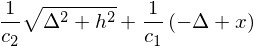

In [20]:
T = (x - D)/c_1 + sym.sqrt(h**2 + D**2)/c_2
T

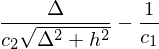

In [23]:
dTdH = T.diff(D)
dTdH

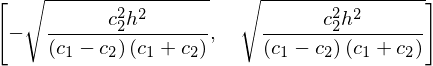

In [5]:
roots = sym.solve(dTdH, D)
roots

We throw out the negative root since $\Delta$ was defined to be positive

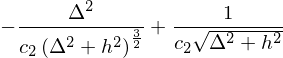

In [38]:
ddTddH = dTdH.diff(D)
display(ddTddH)
ddTddH.replace(D, roots[1]).subs({c_1: 100, c_2: 10, h:0.01})

Thus we indeed have a minima.

In [41]:
roots[1].subs({c_2: 10, c_1: 1000, h:.1}).n()

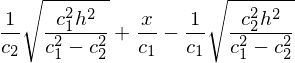

In [6]:
T = T.replace(D, roots[1]).simplify()
T

Shuffling around terms one gets the following linear relationship with $x, \beta, \gamma, a, b$

> $T = \frac{h}{c_2}(1- \beta^2)^{-1/2}+ \frac{1}{c_1}(x - \beta h (1- \beta^2)^{-1/2})$

> $T = \frac{h}{c_1}(1- \beta^2)^{-1/2}(\beta^{-1} + \frac{x}{h} - \beta)$

> $T = b + a x$

- $\beta \equiv \frac{c_2}{c_1}$

- $\gamma \equiv (1 - \beta^2)^{-1/2} $

- $a = \frac{\gamma}{c_1}$

- $b = h(\beta^{-1} - \beta)\frac{\gamma}{c_1}$

Thus, solving for $b$ and $a$ can be done using a linear fit.

Note that $b$ and $a$ are related by a factor of $h (\beta^{-1} - \beta)$

Thus:

> $\frac{b}{h a} = \beta^{-1} - \beta$

Multiplying by $\beta$ we get

> $\beta^2 + \frac{b}{h a}\beta - 1 = 0$

In [7]:
beta, b, a = sym.symbols("beta b a")

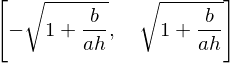

In [8]:
roots_beta = sym.solve(beta**2 - b/(h*a) - 1, beta)
roots_beta

We can throw out the negative result since $c_1 \wedge c_2 > 0$ impling $\beta=c_2/c_1$ is positive.

With $\beta$ estimated, a series of $T$ measurements can be recast as a linear system w.r.t. $\frac{1}{c_1}$ and $\frac{1}{c_2}$

Thus, determining $c_1$ which in turn induces the mode frequencies: $\frac{c}{R} \alpha_{mn}$